In [1]:
import numpy as np
import scipy.signal as signal
import random
import cvxpy as cp
from helper import awgn, draw, draw_3d, hermitian, RMSE, findNMaxPeaks
import time
import matplotlib.pyplot as plt
import sys
epsilon = 1e-11

(100, 500)


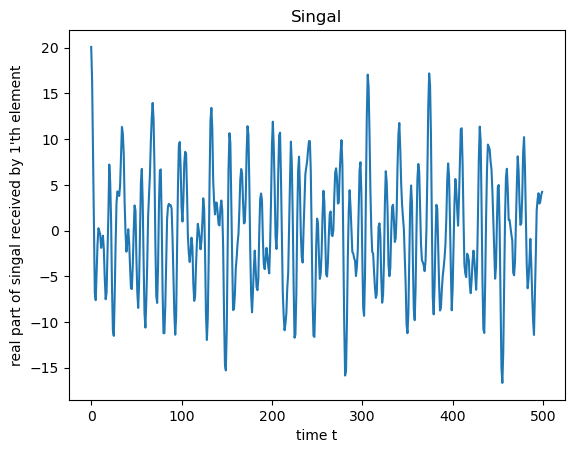

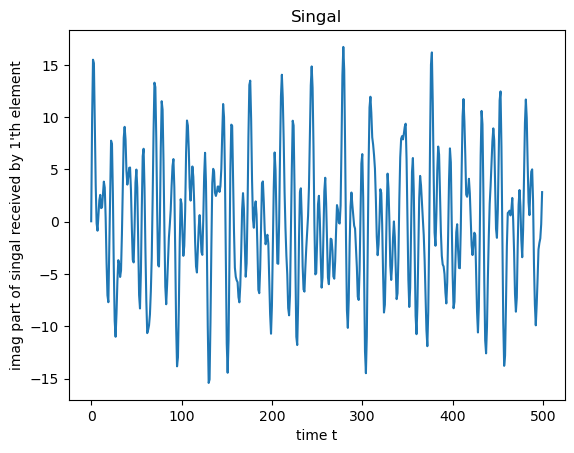

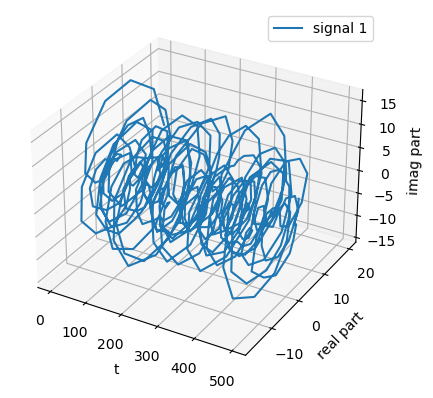

In [2]:
N = 0
M = 0
f = []
a = lambda f : np.array([ np.exp(-1j* i * 2 * np.pi * f ) for i in range(M) ], dtype=complex).reshape((M,1))

# signal model
def create_signal(snr, numSample, numArrElem, numFreq=None, freqs=None):
  global N,M,f,a
  N = numSample # number of samples
  M = numArrElem # number of arr elem
  f = []
  if (type(freqs) != type(None)):
    f = freqs
  else:
    intervals = np.linspace(0,1,numFreq+1)
    width = intervals[1]
    for k in range(len(intervals)):
      if (k==0):
        continue
      f.append(random.random() * (width) + (intervals[k-1]))
    f.sort()
  A = np.hstack([ a(ff) for ff in f ])
  s = lambda f : 2 * np.exp( 1j * f * np.array(range(N)).reshape((N,1)) )
  S = np.hstack([ s(ff) for ff in f ]).T
  X = A @ S
  X += np.array([awgn(X[i], snr) for i in range(M)])
  return X
X = create_signal(0.8, numSample=500, numArrElem=100, numFreq=5)
print(X.shape)
draw(list(range(N)), np.real(X[0,:]), "time t", "real part of singal received by {}'th element".format(0+1), "Singal")
draw(list(range(N)), np.imag(X[0,:]), "time t", "imag part of singal received by {}'th element".format(0+1), "Singal")
draw_3d(list(range(N)), np.real(X[0,:]), np.imag(X[0,:]), "t", "real part", "imag part")

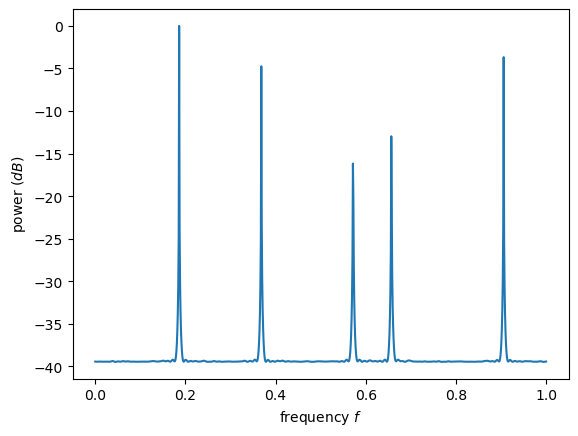

In [3]:
def MUSIC(X, numFreq, numSampling):
  Rxx = X @ hermitian(X)
  eigVal, eigVec = np.linalg.eigh(Rxx)
  NN = eigVec[:, 0:M-numFreq-1]
  Pmusic = np.array([ 0.0 for _ in range(numSampling) ])
  for ii in range(numSampling):
    fx = (1-0)/numSampling * ii
    SS = np.array([np.exp( -1j * 2 * np.pi * k * fx ) for k in range(M)])
    P = hermitian(SS) @ (NN @ hermitian(NN)) @ SS
    if (np.abs(P) == 0):
      P = sys.maxsize
    Pmusic[ii] = 1 / np.abs(P)
  pMax = np.max(Pmusic)
  Pmusic = np.real(10*np.log10(Pmusic/pMax))
  # Pmusic = np.real(Pmusic/pMax)
  return Pmusic

xx = np.linspace(0,1,1000)
y = MUSIC(X,len(f), 1000)
draw(xx,y,"frequency $f$","power $(dB)$","")

In [4]:
peaks, props = signal.find_peaks(y, prominence=len(f))
print(f)
print(xx[peaks])
print(RMSE(xx[peaks],f))

[0.1860578734272117, 0.3681027527338771, 0.5713815809564055, 0.6562656766754679, 0.9049116749457797]
[0.18618619 0.36836837 0.57157157 0.65665666 0.90590591]
0.0005028862318689684


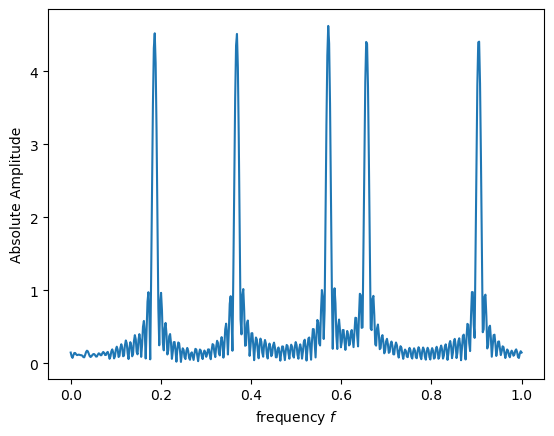

In [5]:
def ANM(x):
  c = cp.Constant(np.ones((1,1)))
  p = cp.Variable((M,1), complex=True)
  H = cp.Variable((M,M), complex=True)
  constraints = [ cp.bmat([
    [ H, p],
    [ p.H, c ]
  ]) >> 0 ]
  superDiagonal = lambda k : [ H[i,i+k] for i in range(M-k) ]
  delta = lambda k : 1 if (k == 0) else 1
  constraints += [ cp.sum(superDiagonal(k)) == delta(k) for k in range(M) ] 

  prob = cp.Problem(cp.Maximize( cp.real( cp.scalar_product(x,p) ) ), constraints)
  prob.solve()

  return p.value, H.value
  

def calcFreq(p,H,N):
  graphX = np.linspace(0,1,N)
  graphY = np.zeros((N))
  for i in range(len(graphX)):
    tau = graphX[i]
    P = hermitian(a(tau)) @ p
    graphY[i] = np.sqrt(np.real(P)**2 + np.imag(P)**2)
  return graphX, graphY


p, H = ANM(X[:,0].reshape(M,1))
graphX, graphY = calcFreq(p,H,N)
draw(graphX, graphY, "frequency $f$", "Absolute Amplitude", "")

In [6]:
peaks, props = signal.find_peaks(graphY, height =4)

print(graphX[peaks])
print(RMSE(graphX[peaks],f))


[0.18637275 0.36873747 0.57114228 0.65531062 0.90581162]
0.0006754727667406773


In [8]:
def test_speed(numSamples, numArrayElem, numFreqs=None, freqs=None):
  X = create_signal(1, numSample=numSamples, numArrElem=numArrayElem, numFreq=numFreqs) if type(freqs) == type(None) else create_signal(1, numSample=numSamples, numArrElem=numArrayElem, freqs=freqs)
  t0 = time.time()
  MUSIC(X, len(freqs) if type(numFreqs) == type(None) else numFreqs, 1000)
  t1 = time.time()
  print("MUSIC: {}s".format(t1-t0))
  t2 = time.time()
  ANM(X[:,0].reshape(M,1))
  t3 = time.time()
  print("ANM: {}s".format(t3-t2))
  return t1-t0, t3-t2
  

0.0 [0.2, 0.5, 0.8] [0.86357271 0.13662733 0.4674935 ] [0.49989998 0.16923385 0.83076615] 0.055118836885542734 0.025120525294563375
0.010101010101010102 [0.2, 0.5, 0.8] [0.50010002 0.81776355 0.18243649] [0.20784157 0.79215843 0.49989998] 0.014422560883949723 0.006402874126434155
0.020202020202020204 [0.2, 0.5, 0.8] [0.78615723 0.21404281 0.50010002] [0.20544109 0.79455891 0.49989998] 0.011384678556927673 0.004443005213649841
0.030303030303030304 [0.2, 0.5, 0.8] [0.71974395 0.28045609 0.78575715] [0.80136027 0.19863973 0.49989998] 0.13535563573935383 0.0011121576814496713
0.04040404040404041 [0.2, 0.5, 0.8] [0.50010002 0.84376875 0.15643129] [0.49989998 0.18763753 0.81236247] 0.035655512084821546 0.010094081704241066
0.05050505050505051 [0.2, 0.5, 0.8] [0.81596319 0.18423685 0.50010002] [0.17823565 0.82176435 0.49989998] 0.012952612401483665 0.01777061353049781
0.06060606060606061 [0.2, 0.5, 0.8] [0.84356871 0.15663133 0.41928386] [0.15003001 0.84996999 0.58371674] 0.058578068866586765

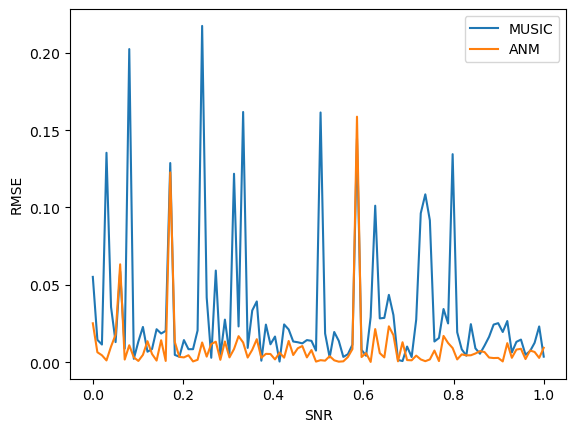

In [9]:
def test_error(k):
  X = create_signal(k,1,10,None,[0.2,0.5,0.8])
  freq = f
  yMusic = MUSIC(X, 1, 5000)
  p,H = ANM(X[:,0].reshape(M,1))
  graphX, graphY_ANM = calcFreq(p,H,5000)
  peaks_MUSIC, props = signal.find_peaks(yMusic)
  peaks_ANM, props = signal.find_peaks(graphY_ANM)
  peaks_MUSIC = peaks_MUSIC[findNMaxPeaks(yMusic, peaks_MUSIC, 3)]
  peaks_ANM = peaks_ANM[findNMaxPeaks(graphY_ANM, peaks_ANM, 3)]
  rmse1 = RMSE(np.sort(graphX[peaks_MUSIC]),freq)
  rmse2 = RMSE(np.sort(graphX[peaks_ANM]),freq)
  print(k, freq, graphX[peaks_MUSIC], graphX[peaks_ANM], rmse1, rmse2)
  return rmse1, rmse2

iterList = np.linspace(0,1,100)
rmse_MUSIC = []
rmse_ANM = []
for k in iterList:
  rmse1, rmse2 = test_error(k)
  rmse_MUSIC.append(rmse1)
  rmse_ANM.append(rmse2)
plt.xlabel("SNR")
plt.ylabel("RMSE")
plt.plot(iterList, rmse_MUSIC, label = "MUSIC")
plt.plot(iterList, rmse_ANM, label = "ANM")
plt.legend()
plt.show()

[0.3, 0.31] [0.30886177 0.52270454] [0.30506101 0.44708942]
0.15053529940220464 0.097002892586178 0 0
[0.3, 0.3101803607214429] [0.30486097 0.47589518] [0.14722945 0.30506101]
0.11722847363085015 0.10808572970699382 0 0
[0.3, 0.31036072144288573] [0.31166233 0.82996599] [0.30526105 0.75435087]
0.36750894440471105 0.31397048495094954 0 0
[0.3, 0.31054108216432863] [0.06281256 0.30606121] [0.16643329 0.30526105]
0.1677467581451315 0.09451969538005432 0 0
[0.3, 0.3107214428857715] [0.08281656 0.30566113] [0.00780156 0.30526105]
0.15361356046145733 0.20665157151881583 0 0
[0.3, 0.3109018036072144] [0.30766153 0.97239448] [0.30546109 0.54470894]
0.4677773287247392 0.16537170464241244 0 0
[0.3, 0.3110821643286573] [0.30526105 0.9629926 ] [0.16403281 0.30546109]
0.4609852995907353 0.09622544918903146 0 0
[0.3, 0.3112625250501002] [0.13162633 0.30806161] [0.12742549 0.30566113]
0.11907967959740162 0.12209287201873 0 0
[0.3, 0.31144288577154305] [0.30746149 0.92318464] [0.06961392 0.30566113]
0

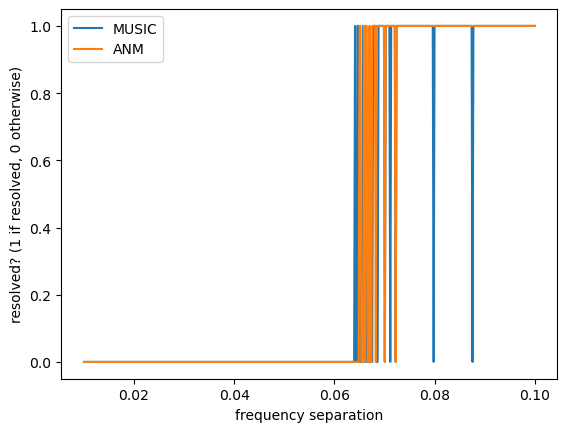

In [10]:
def test_superResolution(separation):
  X = create_signal(1,1,10,None,[0.3, 0.3+separation])
  freq = f
  yMusic = MUSIC(X, 1, 5000)
  p,H = ANM(X[:,0].reshape(M,1))
  graphX, graphY_ANM = calcFreq(p,H,5000)

  peaks_MUSIC, props = signal.find_peaks(yMusic)
  peaks_ANM, props = signal.find_peaks(graphY_ANM)
  peaks_MUSIC = peaks_MUSIC[findNMaxPeaks(yMusic, peaks_MUSIC, 2)]
  peaks_ANM = peaks_ANM[findNMaxPeaks(graphY_ANM, peaks_ANM, 2)]
  print(freq, np.sort(graphX[peaks_MUSIC]), np.sort(graphX[peaks_ANM]))
  # draw(graphX, yMusic, "", "", "")
  # draw(graphX, graphY_ANM, "", "", "")
  ret_MUSIC = 1 if RMSE(np.sort(graphX[peaks_MUSIC]), freq) < 0.05 else 0
  ret_ANM = 1 if RMSE(np.sort(graphX[peaks_ANM]), freq) < 0.05 else 0
  print(RMSE(np.sort(graphX[peaks_MUSIC]), freq),RMSE(np.sort(graphX[peaks_ANM]), freq), ret_MUSIC, ret_ANM)
  return ret_MUSIC, ret_ANM

# test_superResolution(0.01)
boolMUSIC = []
boolANM = []
iterList = np.linspace(0.01,0.1,500)
for separation in iterList:
  bool1, bool2 = test_superResolution(separation)
  boolMUSIC.append(bool1)
  boolANM.append(bool2)
plt.xlabel("frequency separation")
plt.ylabel("resolved? (1 if resolved, 0 otherwise)")
plt.plot(iterList, boolMUSIC, label = "MUSIC")
plt.plot(iterList, boolANM, label = "ANM")
plt.legend()
plt.show()

In [11]:
bothResolved = False
oneResolved = False
for i in range(500):
  x = iterList[i]
  bool1 = boolMUSIC[i]
  bool2 = boolANM[i]
  if (bothResolved and oneResolved):
    break
  if (bool1 == 0 and bool2 == 0):
    continue
  elif (bool1 == 1 and bool2 == 1):
    if (not bothResolved):
      print('both resolved at x= ',x)
      bothResolved = True
  else:
    if (not oneResolved):
      print('{} resolved at x= {}'.format('MUSIC' if bool1 == 1 else 'ANM', x))
      oneResolved = True

MUSIC resolved at x= 0.06410821643286574
both resolved at x=  0.06501002004008016


MUSIC: 0.01295614242553711s
ANM: 0.0724797248840332s
MUSIC: 0.013953447341918945s
ANM: 0.11097455024719238s
MUSIC: 0.015473604202270508s
ANM: 0.17308735847473145s
MUSIC: 0.016035795211791992s
ANM: 0.2146294116973877s
MUSIC: 0.018979787826538086s
ANM: 0.2164905071258545s
MUSIC: 0.020132780075073242s
ANM: 0.2487637996673584s
MUSIC: 0.021926164627075195s
ANM: 0.34660911560058594s
MUSIC: 0.023110151290893555s
ANM: 0.36333727836608887s
MUSIC: 0.025017499923706055s
ANM: 0.4915790557861328s
MUSIC: 0.04457211494445801s
ANM: 0.576500415802002s
MUSIC: 0.04827094078063965s
ANM: 0.7409729957580566s
MUSIC: 0.05542111396789551s
ANM: 0.6488056182861328s
MUSIC: 0.05477404594421387s
ANM: 0.7655782699584961s
MUSIC: 0.05984926223754883s
ANM: 1.028686285018921s
MUSIC: 0.058197021484375s
ANM: 1.2032220363616943s
MUSIC: 0.061879873275756836s
ANM: 0.9417717456817627s
MUSIC: 0.06302285194396973s
ANM: 1.4855146408081055s
MUSIC: 0.06334877014160156s
ANM: 1.5066609382629395s
MUSIC: 0.06632471084594727s
ANM: 1.62

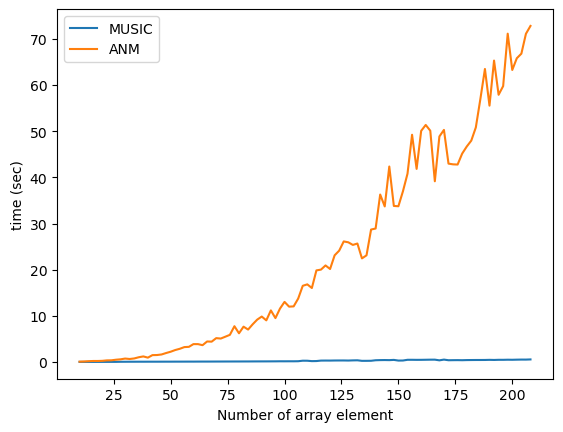

MUSIC: 0.020472049713134766s
ANM: 0.18730378150939941s
MUSIC: 0.019932985305786133s
ANM: 0.271373987197876s
MUSIC: 0.019443750381469727s
ANM: 0.352550745010376s
MUSIC: 0.019941091537475586s
ANM: 0.27217984199523926s
MUSIC: 0.019933462142944336s
ANM: 0.3964273929595947s
MUSIC: 0.018937110900878906s
ANM: 0.31856870651245117s
MUSIC: 0.020365238189697266s
ANM: 0.33661699295043945s
MUSIC: 0.021906375885009766s
ANM: 0.3136012554168701s
MUSIC: 0.01962423324584961s
ANM: 0.3167538642883301s
MUSIC: 0.018576383590698242s
ANM: 0.3156130313873291s
MUSIC: 0.019937992095947266s
ANM: 0.3532392978668213s
MUSIC: 0.019336223602294922s
ANM: 0.29904651641845703s
MUSIC: 0.018936634063720703s
ANM: 0.3220992088317871s
MUSIC: 0.018972396850585938s
ANM: 0.3090481758117676s
MUSIC: 0.018030405044555664s
ANM: 0.33516645431518555s
MUSIC: 0.02047872543334961s
ANM: 0.32598137855529785s
MUSIC: 0.01946258544921875s
ANM: 0.3548405170440674s
MUSIC: 0.0189361572265625s
ANM: 0.3221726417541504s
MUSIC: 0.017940044403076172s

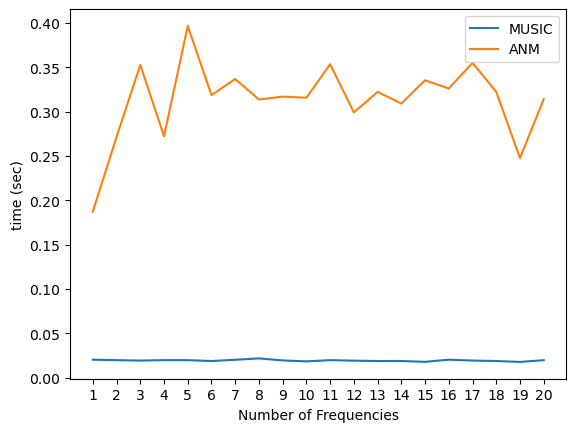

In [12]:
T1 = []
T2 = []
x = []
for k in range(100):
  x.append(10+2*k)
  t1, t2 = test_speed(1, 10+2*k, 5)
  T1.append(t1)
  T2.append(t2)
plt.xlabel("Number of array element")
plt.ylabel("time (sec)")
plt.plot(x, T1, label = "MUSIC")
plt.plot(x, T2, label = "ANM")
plt.legend()
plt.show()
T1 = []
T2 = []
x = []
for k in range(20):
  numFreq = k+1
  x.append(numFreq)
  f = np.linspace(0,1-epsilon, numFreq)
  t1, t2 = test_speed(1, 20, freqs=f)
  T1.append(t1)
  T2.append(t2)
plt.xlabel("Number of Frequencies")
plt.xticks(x)
plt.ylabel("time (sec)")
plt.plot(x, T1, label = "MUSIC")
plt.plot(x, T2, label = "ANM")
plt.legend()
plt.show()